In [1]:
!pip install matplotlib numpy pandas SciencePlots

In [2]:
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import pandas as pd
from typing import cast, Dict, Callable
from format import TimeStampEntity, StepLogEntity, MessageLogEntity, Result, List, Literal, Union
import scienceplots as _
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from itertools import cycle


# Get the directory of the current file
current_dir = os.getcwd()

In [3]:
# # Construct the path to the directory where publish.py is located
# publish_dir = os.path.join(current_dir, "pyblish")

# # Append the directory to sys.path
# sys.path.append(publish_dir)

# # Now you can import the publish module
# import publish

In [4]:
# Load data from all the log files
def load_data_from_files(directory):
    dir_list = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    if len(dir_list) == 0:
        # use the directory as the only directory
        dir_list = [directory]
    for d in dir_list:
        dir_path = os.path.join(directory, d)
        log_files = sorted([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"Loading {len(log_files)} log files from {dir_path}")
        for log_file in log_files:
            log_file_path = os.path.join(dir_path, log_file)
            with open(log_file_path, "r") as file:
                data = json.load(file)
                # print(f"File [{log_file}] loaded: {data['dataHandling']}")
                yield data

def get_full_log_key(log:Result):
    return f"{log['numberOfSimulatedEvents']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_{log['targetFrames']}_{log['browser']}"

def serialize_data(dir_path:str):
    # SET THE PATH TO THE LOG FILE DIRECTORY
    log_dir = os.path.join(current_dir, dir_path )
    data = {}
    for log in load_data_from_files(log_dir):
        log['numberOfSimulatedEvents'] = int(log['numberOfSimulatedEvents'])
        log['numberOfBins'] = int(log['numberOfBins'])
        log['targetFrames'] = float(log['targetFrames'])
        result_log = cast(Result, log)
        # create a new key for the data
        log_key = get_full_log_key(result_log)
        if(log_key not in data):
            data[log_key] = [result_log]
        else:
            data[log_key].append(result_log)
    
    return data

In [5]:
all_electrons_serialized_data: Dict[str, Result] = serialize_data("logs\\allElectronsScenario\\")

Loading 10560 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\allElectronsScenario\


In [6]:
all_protons_serialized_data: Dict[str, Result] = serialize_data("logs\\allProtonsScenario\\")

Loading 3200 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\allProtonsScenario\


In [7]:
# print out dictionary size and keys separated by new lines
print(f"Dictionary size: {len(all_electrons_serialized_data)}")
print("\n".join(all_electrons_serialized_data.keys()))

Dictionary size: 484
1_1_electron_all_processed_0.0_Firefox_127
1_1_electron_all_processed_0.0_Vivaldi_6.8
1_1_electron_all_processed_0.5_Firefox_127
1_1_electron_all_processed_0.5_Vivaldi_6.8
1_1_electron_all_raw_0.0_Firefox_127
1_1_electron_all_raw_0.0_Vivaldi_6.8
1_1_electron_all_raw_0.5_Firefox_127
1_1_electron_all_raw_0.5_Vivaldi_6.8
1_16_electron_all_processed_0.0_Firefox_127
1_16_electron_all_processed_0.0_Vivaldi_6.8
1_16_electron_all_processed_0.5_Firefox_127
1_16_electron_all_processed_0.5_Vivaldi_6.8
1_16_electron_all_raw_0.0_Firefox_127
1_16_electron_all_raw_0.0_Vivaldi_6.8
1_16_electron_all_raw_0.5_Firefox_127
1_16_electron_all_raw_0.5_Vivaldi_6.8
1_256_electron_all_processed_0.0_Firefox_127
1_256_electron_all_processed_0.0_Vivaldi_6.8
1_256_electron_all_processed_0.5_Firefox_127
1_256_electron_all_processed_0.5_Vivaldi_6.8
1_256_electron_all_raw_0.0_Firefox_127
1_256_electron_all_raw_0.0_Vivaldi_6.8
1_256_electron_all_raw_0.5_Firefox_127
1_256_electron_all_raw_0.5_Vivaldi

In [8]:
# print out the first log in readable format
first_key = list(all_electrons_serialized_data.keys())[0]
first_log = all_electrons_serialized_data[first_key]
print(json.dumps(first_log, indent=4))

[
    {
        "iteration": 0,
        "numberOfSimulatedEvents": 1,
        "numberOfBins": 1,
        "particleType": "electron",
        "dataHandling": "all_processed",
        "targetFrames": 0.0,
        "browser": "Firefox_127",
        "resolution": "2347x1320",
        "timeStamps": [
            [
                "testStart",
                38
            ],
            [
                "workerStart",
                766
            ],
            [
                "simulationStart",
                1111
            ],
            [
                "simulationEnd",
                2016
            ],
            [
                "testEnd",
                2034
            ]
        ],
        "stepLogs": [
            {
                "handleStart": 767,
                "optimizeStart": null,
                "renderStart": null,
                "stepEnd": 767,
                "remainingMessages": 0
            },
            {
                "handleStart": 783,
        

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{babel}"
})

In [164]:
def plot_total_time(fig: Figure, 
        ax: Axes, 
        data_list: List[Dict[str,Result]], 
        series_criteria: Dict[str, List[any]], 
        x_label, 
        label_fn: Callable[[Result], str]=get_full_log_key,
        sort_labels: Callable[[str], List[str]]=lambda x: sorted(x)
    ):
    # use custom cycler for line styles and don't use '-'
    custom_linestyles=[(0,(4,2)),(0,(1,1)),'-.', (0,(5,2,1,1,1,2)), ]
    series = {}
    lines = []
    for data in data_list:
        for _, log in data.items():
            label = label_fn(log[0])

            if not all(log[0][k] in v for k, v in series_criteria.items()):
                continue
            if series.get(label) is None:
                series[label] = {"x": [], "y": [], "e": []}
            series[label]["x"].append(int(log[0][x_label]))
            # total time taken is a difference between the last and first timestamp
            all_times = [time_stamps["timeStamps"][-1][1] - time_stamps["timeStamps"][0][1] for time_stamps in log]
            # get average total and std deviation
            average_time_taken = np.mean(all_times)
            std_dev = np.std(all_times)
            
            series[label]["y"].append(average_time_taken)
            series[label]["e"].append(std_dev)
    sorted_labels = sort_labels(series.keys())
    print(sorted_labels)
    for i, k in enumerate(sorted_labels):
        s = series[k]
        # sort the x and y values in all series based on x
        s["x"], s["y"], s["e"] = zip(*sorted(zip(s["x"], s["y"], s["e"])))
        line = ax.plot(s["x"], s["y"], label=k, linestyle=custom_linestyles[i % len(custom_linestyles)])
        lines.append(line)
        # fill in area between the error bars
        ax.fill_between(s["x"], np.array(s["y"]) - np.array(s["e"]), np.array(s["y"]) + np.array(s["e"]), alpha=0.2)
    return zip(sorted_labels, lines)

In [165]:
def generate_plot_with_total_time(series_criteria, x_label, x_key, y_label, plot_args, 
        label_fn: Callable[[Result], str]=get_full_log_key,
        sort_fn: Callable[[str], List[str]]=lambda x: sorted(x)):
    with plt.style.context(['science', 'ieee', 'high-vis']):
        fig, ax = plt.subplots(figsize=(4, 3))
        fig.dpi = 300
        
        # plot the total time taken for each log
        plots = plot_total_time(fig, ax, plot_args, series_criteria, x_key, label_fn, sort_fn)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        print('Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych')
        ax.set_xscale("log", base=2)
        ax.set_yscale("log", base=2)
        ax.grid()
        labels, lines = zip(*plots)
        print(lines, labels)
        ax.legend([(mpatches.Patch(color=line[0].get_color(), linewidth=0, alpha=0.2), line[0]) for line in lines], labels)
        plt.show()

In [166]:
label_fn = lambda log: f'{    "Wizualizacja" if log["dataHandling"] == "all_raw" else "Symulacja"} {"elektronów" if log["particleType"] == "electron" else "protonów"} dla {log["browser"]}'
sort_fn = lambda x: sorted(x, key=lambda x: x.split(' ')[-1]) 

['Symulacja elektronów dla Firefox_127', 'Wizualizacja elektronów dla Firefox_127', 'Symulacja elektronów dla Vivaldi_6.8', 'Wizualizacja elektronów dla Vivaldi_6.8']
Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych
([<matplotlib.lines.Line2D object at 0x000001D9A014B190>], [<matplotlib.lines.Line2D object at 0x000001D9A01024D0>], [<matplotlib.lines.Line2D object at 0x000001D99AE5D410>], [<matplotlib.lines.Line2D object at 0x000001D99A107E90>]) ('Symulacja elektronów dla Firefox_127', 'Wizualizacja elektronów dla Firefox_127', 'Symulacja elektronów dla Vivaldi_6.8', 'Wizualizacja elektronów dla Vivaldi_6.8')


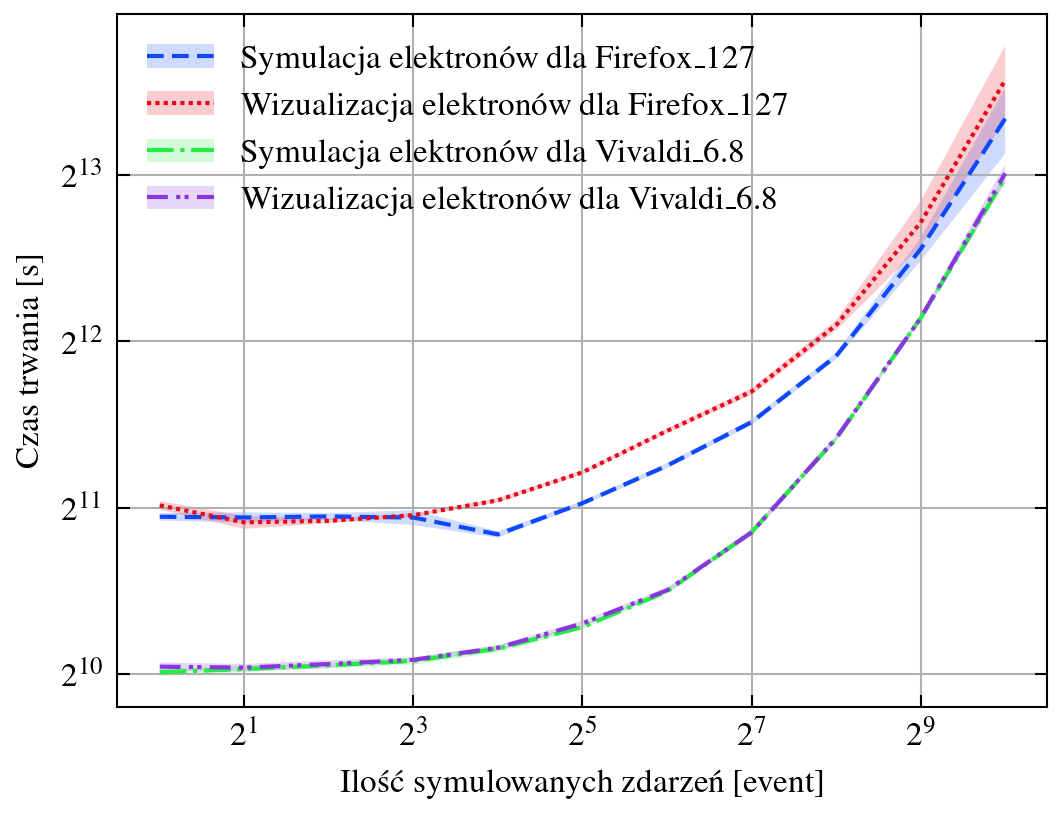

In [167]:
generate_plot_with_total_time(
    series_criteria=dict(dataHandling=['all_raw', 'all_processed', 'none'], numberOfBins=[256], targetFrames=[0]),
    x_label='Ilość symulowanych zdarzeń [event]',
    x_key='numberOfSimulatedEvents',
    y_label='Czas trwania [s]',
    plot_args=[all_electrons_serialized_data],
    label_fn=label_fn, 
    sort_fn=sort_fn
)

['Symulacja elektronów dla Firefox_127', 'Wizualizacja elektronów dla Firefox_127', 'Symulacja elektronów dla Vivaldi_6.8', 'Wizualizacja elektronów dla Vivaldi_6.8']
Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych
([<matplotlib.lines.Line2D object at 0x000001D9A0463490>], [<matplotlib.lines.Line2D object at 0x000001D9A0460290>], [<matplotlib.lines.Line2D object at 0x000001D9A0476690>], [<matplotlib.lines.Line2D object at 0x000001D99A594E50>]) ('Symulacja elektronów dla Firefox_127', 'Wizualizacja elektronów dla Firefox_127', 'Symulacja elektronów dla Vivaldi_6.8', 'Wizualizacja elektronów dla Vivaldi_6.8')


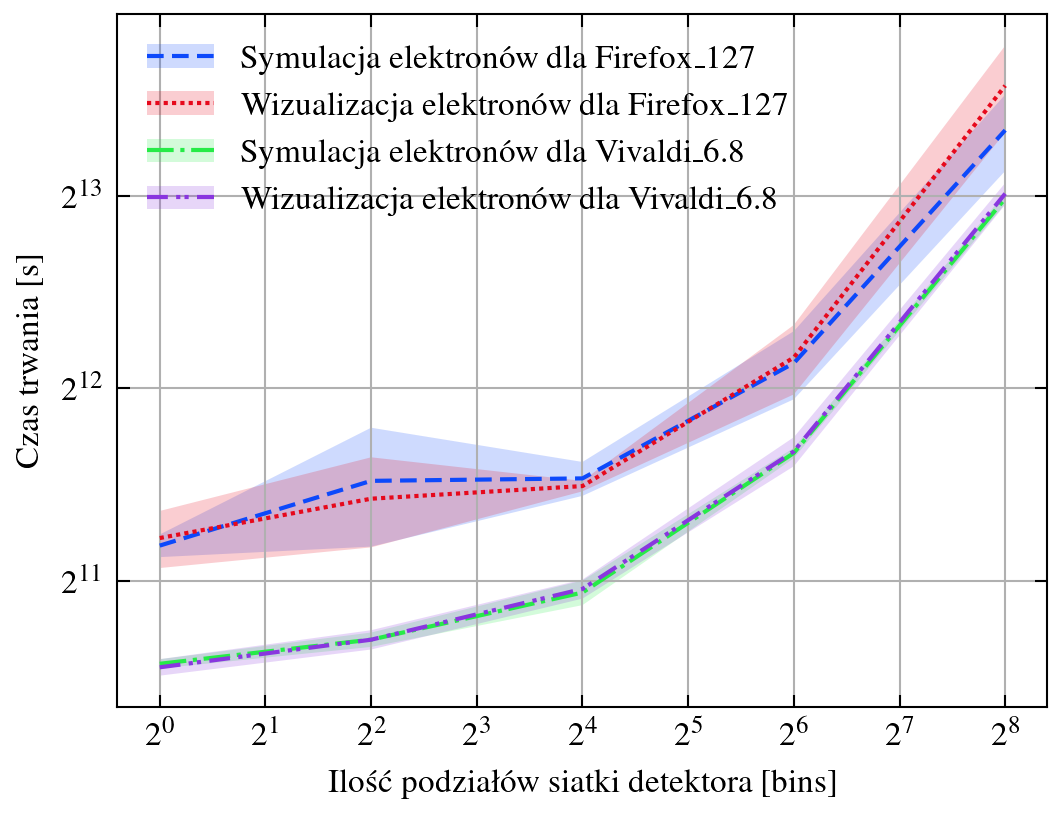

In [179]:
generate_plot_with_total_time(
    series_criteria=dict(dataHandling=['all_raw', 'all_processed', 'none'], numberOfSimulatedEvents=[1024], targetFrames=[0]),
    x_label="Ilość podziałów siatki detektora [bins]",
    x_key='numberOfBins',
    y_label='Czas trwania [s]',
    plot_args=[all_electrons_serialized_data],
    label_fn = label_fn,
    sort_fn = sort_fn
)

In [ ]:
def stacked_time_separated_by_phase(fig: Figure, 
        ax: Axes, 
        data_list: List[Dict[str,Result]], 
        series_criteria: Dict[str, List[any]], 
        x_label, 
        label_fn: Callable[[Result], str]=get_full_log_key,
        sort_labels: Callable[[str], List[str]]=lambda x: sorted(x)
    ):
    series = {}
    for data in data_list:
        for _, log in data.items():
            label = label_fn(log[0])

            if not all(log[0][k] in v for k, v in series_criteria.items()):
                continue
            if series.get(label) is None:
                series[label] = {"x": [], "y": [], "e": []}
            series[label]["x"].append(int(log[0][x_label]))
            # total time taken is a difference between the last and first timestamp
            all_times = [time_stamps["timeStamps"][-1][1] - time_stamps["timeStamps"][0][1] for time_stamps in log]
            # get average total and std deviation
            average_time_taken = np.mean(all_times)
            std_dev = np.std(all_times)
            
            series[label]["y"].append(average_time_taken)
            series[label]["e"].append(std_dev)
    sorted_labels = sort_labels(series.keys())
    print(sorted_labels)
    for i, k in enumerate(sorted_labels):
        s = series[k]
        # sort the x and y values in all series based on x
        s["x"], s["y"], s["e"] = zip(*sorted(zip(s["x"], s["y"], s["e"])))
        line = ax.plot(s["x"], s["y"], label=k, linestyle=custom_linestyles[i % len(custom_linestyles)])
        lines.append(line)
        # fill in area between the error bars
        ax.fill_between(s["x"], np.array(s["y"]) - np.array(s["e"]), np.array(s["y"]) + np.array(s["e"]), alpha=0.2)
    return zip(sorted_labels, lines)